In [2]:
import urllib.request
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import shutil
import numpy as np
import pandas as pd
import time

import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras import optimizers
import matplotlib.pyplot as plt;
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

import gc

In [3]:
BASE_DIR = '..'
RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, '-ImageAquisition', 'data','processed')
MUNICIPALITIES_DIR = os.path.join(BASE_DIR, '2-ImageAquisition', 'data','muncipalities')


PROCESSED = os.path.join(BASE_DIR, '3-FeatureExtraction')
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, '1-ValeRibeira-Data', 'data','processed')

# these relate to training the CNN to predict nightlights
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, 'data', 'cnn_images')
CNN_SAVE_DIR = os.path.join(BASE_DIR, 'models')

CONS_PC_COLUMN = 'RendaIDHM'


In [4]:
def downloadImage(img):
#  
    urllib.request.urlretrieve(
      'https://parsec-brazil-images.s3.amazonaws.com/vale-ribeira/'+img,
       "temp.png")
    temp = Image.open("temp.png") 
    #Image.close()
    return temp.resize((256, 256))
    temp.close()

In [5]:
df = pd.read_csv(os.path.join(PROCESSED, 'df_geo.csv'))
df

,image_name,NM_MUNICIP,image_lat,image_lon,cluster_lat,cluster_lon,features,area,geometry,setor,Unnamed: 0,lat,long,TIPO,income,longevity,literacy,population
0,-24.328745942316303_-49.111388246241354_-24.42...,APIAÍ,-24.328746,-49.111388,-24.421470,-48.817357,"{'type': 'center_point', 'coordinates': [-24.3...",MULTIPOLYGON(((-48.5833786383066 -24.337911414...,POINT (-49.11138824624136 -24.328745942316303),350270530000002,51.0,-49.049589,-24.310839,RURAL,0.436439,0.800000,0.964335,339.0
1,-24.328745942316303_-49.102875278251105_-24.42...,APIAÍ,-24.328746,-49.102875,-24.421470,-48.817357,"{'type': 'center_point', 'coordinates': [-24.3...",MULTIPOLYGON(((-48.5833786383066 -24.337911414...,POINT (-49.10287527825111 -24.328745942316303),350270530000002,51.0,-49.049589,-24.310839,RURAL,0.436439,0.800000,0.964335,339.0
2,-24.320947354200456_-49.102875278251105_-24.42...,APIAÍ,-24.320947,-49.102875,-24.421470,-48.817357,"{'type': 'center_point', 'coordinates': [-24.3...",MULTIPOLYGON(((-48.5833786383066 -24.337911414...,POINT (-49.10287527825111 -24.320947354200452),350270530000002,51.0,-49.049589,-24.310839,RURAL,0.436439,0.800000,0.964335,339.0
3,-24.336544530432146_-49.09436231026086_-24.421...,APIAÍ,-24.336545,-49.094362,-24.421470,-48.817357,"{'type': 'center_point', 'coordinates': [-24.3...",MULTIPOLYGON(((-48.5833786383066 -24.337911414...,POINT (-49.094362310260856 -24.336544530432143),350270530000002,51.0,-49.049589,-24.310839,RURAL,0.436439,0.800000,0.964335,339.0
4,-24.328745942316303_-49.09436231026086_-24.421...,APIAÍ,-24.328746,-49.094362,-24.421470,-48.817357,"{'type': 'center_point', 'coordinates': [-24.3...",MULTIPOLYGON(((-48.5833786383066 -24.337911414...,POINT (-49.094362310260856 -24.328745942316303),350270530000002,51.0,-49.049589,-24.310839,RURAL,0.436439,0.800000,0.964335,339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31146,-24.70493405897603_-49.22055342451572_-24.6253...,DOUTOR ULYSSES,-24.704934,-49.220553,-24.625378,-49.392223,"{'type': 'center_point', 'coordinates': [-24.7...",MULTIPOLYGON(((-49.4038750791893 -24.498103035...,POINT (-49.220553424515714 -24.70493405897603),412863305000006,872.0,-49.267460,-24.712696,RURAL,0.407464,0.750000,0.933594,381.0
31147,-24.782637892796757_-49.21201519318726_-24.625...,DOUTOR ULYSSES,-24.782638,-49.212015,-24.625378,-49.392223,"{'type': 'center_point', 'coordinates': [-24.7...",MULTIPOLYGON(((-49.4038750791893 -24.498103035...,POINT (-49.212015193187256 -24.78263789279676),412863305000007,873.0,-49.240663,-24.764145,RURAL,0.502978,0.716667,0.896348,220.0
31148,-24.774867509414683_-49.21201519318726_-24.625...,DOUTOR ULYSSES,-24.774868,-49.212015,-24.625378,-49.392223,"{'type': 'center_point', 'coordinates': [-24.7...",MULTIPOLYGON(((-49.4038750791893 -24.498103035...,POINT (-49.212015193187256 -24.774867509414683),412863305000007,873.0,-49.240663,-24.764145,RURAL,0.502978,0.716667,0.896348,220.0
31149,-24.76709712603261_-49.21201519318726_-24.6253...,DOUTOR ULYSSES,-24.767097,-49.212015,-24.625378,-49.392223,"{'type': 'center_point', 'coordinates': [-24.7...",MULTIPOLYGON(((-49.4038750791893 -24.498103035...,POINT (-49.212015193187256 -24.76709712603261),412863305000007,873.0,-49.240663,-24.764145,RURAL,0.502978,0.716667,0.896348,220.0


In [6]:
temp = Image.open("temp.png")     
df['img'] = temp.resize((224, 224))#inputs to VGG are images of 224x224

In [7]:
for index, row in df.iterrows():
    retry = 0
    while (retry < 3):
        try:
            urllib.request.urlretrieve(
              'https://parsec-brazil-images.s3.amazonaws.com/vale-ribeira/'+df['image_name'].loc[index],
               "temp.png")
            temp = Image.open("temp.png")     
            df['img'].loc[index] = temp.resize((224, 224))#inputs to VGG are images of 224x224
            temp.close()
            rotate = 90

            while (rotate < 360):            
                line = df.loc[index]
                line['img'] = Image.Image.rotate(df['img'].loc[index],rotate)
                df = df.append(line, ignore_index=True)
                rotate = rotate + 90

            if index % 100 == 0:
                print("Chegou: ",index, "  ", time.time())
            retry = 4
        except:
            print("Erro: ",index, "  ", time.time(), " retry ", retry)
            retry = retry + 1
    #    if index >= 100:
    #        break;

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-7-697af8384efc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line['img'] = Image.Image.rotate(df['img'].loc[index],rotate)


Chegou:  0    1668621838.5116682
Chegou:  100    1668621852.6061106
Chegou:  200    1668621867.343145
Chegou:  300    1668621881.806513
Chegou:  400    1668621896.8869853
Chegou:  500    1668621911.9430168
Chegou:  600    1668621926.800714
Chegou:  700    1668621942.2978761
Chegou:  800    1668621957.484519
Chegou:  900    1668621972.3376186
Chegou:  1000    1668621987.65959
Chegou:  1100    1668622002.9068363
Chegou:  1200    1668622018.1375525
Chegou:  1300    1668622033.356736
Chegou:  1400    1668622049.1283553
Chegou:  1500    1668622064.5453074
Chegou:  1600    1668622080.289778
Chegou:  1700    1668622095.6352897
Chegou:  1800    1668622111.4884279
Chegou:  1900    1668622127.8484411
Chegou:  2000    1668622143.9690096
Chegou:  2100    1668622161.0292525
Chegou:  2200    1668622176.5747325
Chegou:  2300    1668622192.5466707
Chegou:  2400    1668622209.3983421
Chegou:  2500    1668622225.5199664
Chegou:  2600    1668622241.1471467
Chegou:  2700    1668622256.7595901
Chegou:  280

In [8]:
 print("Chegou: ",index, "  ", time.time())

Chegou:  31150    1668628688.7623606


In [9]:
df['image_name'][0]

'-24.328745942316303_-49.111388246241354_-24.421470335230744_-48.817357310919036.png'

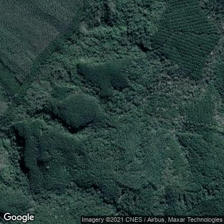

In [10]:
df['img'][0]

In [11]:
print(df['img'][0].format)
print(df['img'][0].size)
print(df['img'][0].mode)

None
(224, 224)
RGB


In [12]:
df['img'].shape

(124604,)

In [13]:
data = np.asarray(df['img'][0])
print(type(data))
# summarize shape
print(data.shape)

# create Pillow image
image2 = Image.fromarray(data)
print(type(image2))

# summarize image details
print(image2.mode)
print(image2.size)

<class 'numpy.ndarray'>
(224, 224, 3)
<class 'PIL.Image.Image'>
RGB
(224, 224)


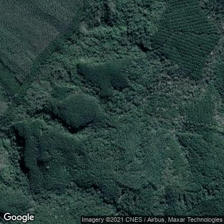

In [14]:
df['img'][0]


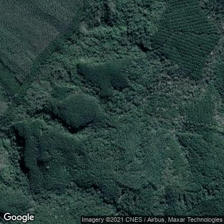

In [15]:
image2

In [16]:
batch_img = []
records = []
for index, row in df.iterrows():
    records.append([df['setor'].loc[index],df['image_name'].loc[index]])#inputs to VGG are images of 224x224)
    #img = image.load_img(df['img'].loc[index], target_size=(224, 224))#inputs to VGG are images of 224x224
    x = image.img_to_array(df['img'].loc[index])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #<class 'numpy.ndarray'> (1, 224, 224, 3) 
    batch_img.append(x)
    #print(df['img'].loc[index])
#    if index >= 1000:
#        break


In [17]:
#del df

gc.collect()
df=pd.DataFrame()

In [18]:
OUT_FILE   = 'vgg_features_2.csv'

In [19]:
base_model = VGG16(weights='imagenet')

In [20]:
model = Model(inputs=base_model.input,
            outputs=base_model.get_layer('fc2').output)#fc2:fully-connected-2

In [21]:
if len(batch_img) >= 0:
    batch_img_arr = np.concatenate(batch_img, axis=0) #(800, 224, 224, 3)
    latent = model.predict(batch_img_arr) #latent space <class 'numpy.ndarray'>, (800, 4096)
    data = pd.concat([
        pd.DataFrame.from_records(records),
        pd.DataFrame(latent)
        ], axis=1)
    data.to_csv(OUT_FILE, header=None, mode='a', index=None)


In [24]:
OUT_FILE

'vgg_features_2.csv'